# MNIST Classification using TenSEAL

Training on unencrypted data

Inference using a neural network with a convolutional layer and 2 FC-layers and square activation function

In [6]:
import tenseal as ts
import numpy as np
import torch
import pickle
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torchvision import datasets

In [7]:
class Conv_Mnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = torch.nn.Conv2d(1, 4, kernel_size=7, padding=0, stride=3)
        self.fc1 = nn.Linear(256,30)
        self.fc2 = nn.Linear(30,10)
        # images are 28x28 ("size")
        # (size + 2*padding - kernel_size) / stride + 1 = 256
        
    def forward(self, x):
        x = self.conv(x).square()
        # flattening while keeping the batch axis
        x = x.view(-1, 256)
        x = self.fc1(x).square()
        x = self.fc2(x)
        return x

In [8]:
# Definitions
def get_data(train_ds, valid_ds, test_ds, bs):
    return ( DataLoader(train_ds, batch_size=bs, shuffle=True),
             DataLoader(valid_ds, batch_size=bs * 2), 
             DataLoader(test_ds, batch_size=1), )

def loss_batch(model, loss_func, xb, yb, opt=None):
    y_pred = model(xb)
    loss = loss_func(y_pred, yb)
    acc = accuracy(y_pred, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), acc, len(xb)

def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [9]:
# Model & Data
loss_func = F.cross_entropy
lr = 0.01
epochs = 10
bs = 64

# Model
model = Conv_Mnist()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay = 1e-4)

# Data
train_data = datasets.MNIST('data', train=True, download=False, transform=transforms.ToTensor())
train_ds, valid_ds = torch.utils.data.random_split(train_data, [50000, 10000])
test_ds = datasets.MNIST('data', train=False, download=False, transform=transforms.ToTensor())
    
train_dl, valid_dl, test_dl = get_data(train_ds, valid_ds, test_ds, bs)

In [10]:
# LEARNING
print("  |   TRAINING    |     TEST")
print("ep|  loss   acc   |  loss   acc")
print("---------------------------------")
for epoch in range(epochs):
    model.train()
    losses, accs, counts = zip(*[loss_batch(model, loss_func, xb, yb, opt) for xb,yb in train_dl])
    train_loss = np.sum(np.multiply(losses,counts)) / np.sum(counts)
    train_acc = np.sum(np.multiply(accs,counts)) / np.sum(counts)
    
    model.eval()
    with torch.no_grad():
        losses, accs, counts = zip(*[loss_batch(model, loss_func, xb, yb) for xb,yb in valid_dl])
        
    eval_loss = np.sum(np.multiply(losses,counts)) / np.sum(counts)
    eval_acc = np.sum(np.multiply(accs,counts)) / np.sum(counts)
    
    print(f"{epoch+1:2d}| {train_loss:.4f} {train_acc:.4f} | {eval_loss:.4f} {eval_acc:.4f}")

  |   TRAINING    |     TEST
ep|  loss   acc   |  loss   acc
---------------------------------
 1| 0.5742 0.8142 | 0.1886 0.9497
 2| 0.1580 0.9561 | 0.1610 0.9605
 3| 0.1269 0.9644 | 0.1221 0.9644


KeyboardInterrupt: 

In [6]:
# save model parameters
file = None
params = dict()

params["conv_w"] = model.conv.weight.data.view(model.conv.out_channels, model.conv.kernel_size[0],
        model.conv.kernel_size[1])
params["conv_b"] = model.conv.bias.data.tolist()
params["fc1_w"] = model.fc1.weight.T.data
params["fc1_b"] = model.fc1.bias.data
params["fc2_w"] = model.fc2.weight.T.data
params["fc2_b"] = model.fc2.bias.data

file = open(f"data/MNIST_Conv_square.dat", "wb")
pickle.dump(params, file)

file.close()

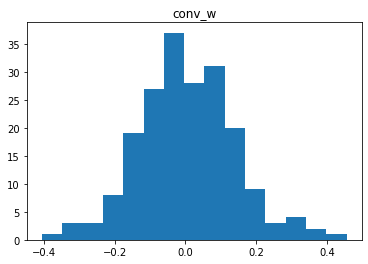

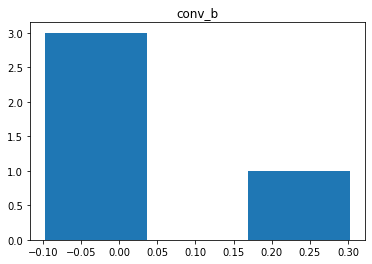

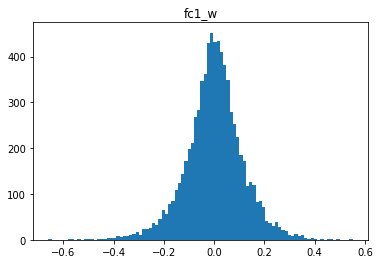

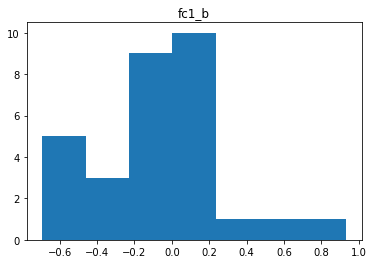

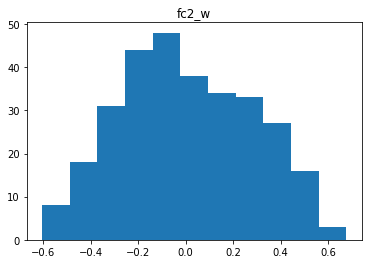

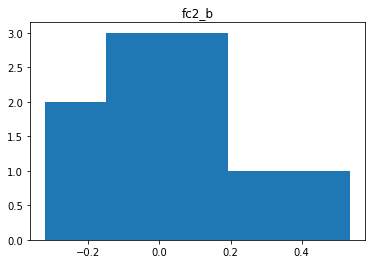

In [7]:
# plot parameter histograms
import numpy as np
import matplotlib.pyplot as plt

def plot(data, title):
    d = np.array(data).flatten()
    _ = plt.hist(d, 'auto')
    plt.title(title)
    plt.show()
    
for k,v in params.items():
    plot(v,k)

In [8]:
# HE handling model
class HE_MNIST_Conv():
    def __init__(self,params):
        self.conv_w = params["conv_w"]
        self.conv_b = params["conv_b"]
        self.fc1_w = params["fc1_w"]
        self.fc1_b = params["fc1_b"]
        self.fc2_w = params["fc2_w"]
        self.fc2_b = params["fc2_b"]
        
        self.ctx = None
        
    def setupHE(self, context):
        self.ctx = ts.context_from(context)
    
    def forward(self, x, windows_nb):
        x = ts.ckks_vector_from(self.ctx, x)
        # conv layer
        enc_channels = []
        for kernel, bias in zip(self.conv_w, self.conv_b):
            y = x.conv2d_im2col(kernel, windows_nb)
            y += bias
            enc_channels.append(y)
        # pack all channels into a single flattened vector
        x = ts.CKKSVector.pack_vectors(enc_channels)
        x.square_()
        # fc1 layer
        x = x.mm(self.fc1_w) + self.fc1_b
        x.square_()
        # fc2 layer
        x = x.mm(self.fc2_w) + self.fc2_b
        return x.serialize()
    
    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

In [9]:
# SEAL Context
bits_scale = 26
    
# Create TenSEAL context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]
)

context.global_scale = pow(2, bits_scale)
context.generate_galois_keys()

In [10]:
# server context
server_context = context.copy()
server_context.make_context_public()
server_context = server_context.serialize()

parms_dict = pickle.load(open(f"data/MNIST_Conv_square.dat", "rb"))
HE_model = HE_MNIST_Conv(parms_dict)
    
HE_model.setupHE(server_context)

In [14]:
# INFERENCE
kernel_x = 7
kernel_y = 7
stride = 3
total_loss = 0
correct = 0
total_items = 0
x_enc = None

print_every_n_items = 10
end_after = 200

print(f"Inference:\n(Model:{str(type(HE_model))[17:-1]}, Activation: square)\n")

if print_every_n_items == 1:
    print(" Label | Prdct |   Loss   |  Acc")
    print("-----------------------------------")
else:
    print(" #items | #correct | cum.Loss |  Acc")
    print("---------------------------------------")
    
    
for x,y in test_dl:
    x_enc, windows_nb = ts.im2col_encoding(context, x.view(28, 28).tolist(), kernel_x, kernel_y, stride)
    
    output_enc = HE_model(x_enc.serialize(), windows_nb)
      
    output_enc = ts.ckks_vector_from(context, output_enc)
    output = output_enc.decrypt()
    output = torch.tensor(output).view(1, -1)
    
    loss = loss_func(output,y)
    total_loss += loss.item()
    
    pred = np.argmax(output)
    correct += int(np.argmax(output) == y.item())
    total_items += 1
    
    if print_every_n_items == 1:
        print(f"   {y.item()}   |   {pred}   | {loss.item():.6f} | {correct/total_items:.4f}")
    elif total_items % print_every_n_items == 0:
        print(f"  {total_items:4}  |   {correct:4}   | {total_loss:.6f} | {correct/total_items:.4f}")
    
    if total_items >= end_after:
        break

Inference:
(Model:HE_MNIST_Conv', Activation: square)

 #items | #correct | cum.Loss |  Acc
---------------------------------------
    10  |     10   | 0.177172 | 1.0000
    20  |     20   | 0.256076 | 1.0000
    30  |     30   | 0.336721 | 1.0000
    40  |     40   | 0.364192 | 1.0000
    50  |     50   | 0.501371 | 1.0000
    60  |     60   | 0.511798 | 1.0000
    70  |     70   | 1.977062 | 1.0000
    80  |     80   | 2.165847 | 1.0000
    90  |     90   | 2.170224 | 1.0000
   100  |     99   | 4.185300 | 0.9900
   110  |    109   | 4.215212 | 0.9909
   120  |    119   | 4.680710 | 0.9917
   130  |    129   | 4.824261 | 0.9923
   140  |    139   | 4.825598 | 0.9929
   150  |    149   | 4.854844 | 0.9933
   160  |    158   | 5.876540 | 0.9875
   170  |    168   | 5.878787 | 0.9882
   180  |    178   | 6.516470 | 0.9889
   190  |    188   | 6.581466 | 0.9895
   200  |    198   | 7.549630 | 0.9900
